In [ ]:
# Importing all the required libraries

import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Layer, Embedding, Dense, MultiHeadAttention, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Loading Wine Reviews dataset
df = pd.read_csv("winemag-data-130k-v2.csv")
texts = df['description'].astype(str).tolist()

# Tokenization and sequence padding
vocab_size = 10000
maxlen = 50
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding="post")

# Layer for custom position and token embedding
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[-1], delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Transformer Block
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):  # Ensure training is passed
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)

# Building the GPT Model
embed_dim = 64
num_heads = 2
ff_dim = 128

inputs = tf.keras.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training=True)
x = Dense(64, activation="relu")(x)
x = Dense(vocab_size, activation="softmax")(x)

model = Model(inputs=inputs, outputs=x)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Training the model
train_data = padded_sequences[:5000]
train_labels = np.roll(train_data, shift=-1, axis=1)

model.fit(train_data, train_labels, batch_size=32, epochs=3)

# Saving the model
model.save("gpt_wine_reviews.h5")


Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 95s 569ms/step - accuracy: 0.1832 - loss: 6.5361
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 97s 615ms/step - accuracy: 0.3483 - loss: 4.2681
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 137s 583ms/step - accuracy: 0.3790 - loss: 3.8656


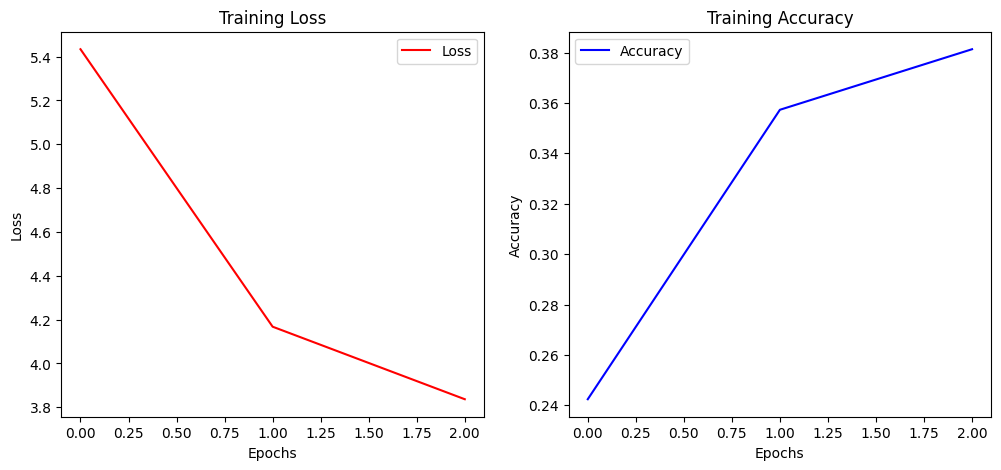

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Generated text: is <UNK> a soft <UNK> <UNK> a of the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> this


In [ ]:
import matplotlib.pyplot as plt

# Loading the model from history
history = model.history.history

# Plotting the training loss and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label="Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label="Accuracy", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.show()

# Generating the sample text prediction
sample_text = ["This wine has a rich flavor with hints of"]
sample_seq = tokenizer.texts_to_sequences(sample_text)
padded_sample = pad_sequences(sample_seq, maxlen=maxlen, padding="post")

predicted = model.predict(padded_sample)
predicted_word_index = np.argmax(predicted[0], axis=-1)

# Converting the predicted token IDs to words
predicted_words = [tokenizer.index_word.get(idx, "<UNK>") for idx in predicted_word_index]

print("Generated text:", " ".join(predicted_words))


In conclusion, training of our GPT model on the Wine Reviews dataset experienced an upward spiral in accuracy of three epochs-from 18.32% to 37.90%-where the loss gained a downward disguise from 6.54 to 3.87. Despite this progress, whatever text was generated possessed far too many <UNK> tokens which indicate a lack of vocabulary coverage and hence limit the model's ability to generalize. This was taken to suggest that either a larger dataset is required, or extending the training period, albeit some more hyperparameters such as embedding size and transformer layers may be tuned for the sake of better text coherence. But the future endeavors might continue to incorporate better preprocessing techniques together with training on more diverse wine reviews to enhance vocabulary recognition and contextual predictions.